# Importing Necessary Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib as mpl
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import quantity_support, astropy_mpl_style
import h5py as h5
from astropy.cosmology import LambdaCDM
from astropy.convolution import convolve_fft
from spectral_cube import SpectralCube
from functions import *

plt.style.use('default')

mpl.rcParams['image.origin'] = 'lower'


mpl.rc('image', origin="lower")
mpl.rc('grid', linestyle='-', linewidth=0.5, color='gray', alpha=0.8)


# Loading the raw mock IFU cube data from FIRE simulations

# The IFU data is of the specific intensity $I_{CII}$ with the units $erg/s/cm^2/Hz/sr$
## To convert it to $Jy/px$ we first need to calculate convert specific intensity into flux density, which involves first integrating over solid angle for each pixel
### The solid angle for each pixel $\Omega_{px} = \theta_{px} \times \phi_{px}$ where $\theta_{px}$ and $\phi_{px}$ are the horizontal and vertical angular resolutions of the pixel. This is done by estimating the angular diameter distance to the redshift of the system, and calculating the angular resolution from the known spatial resolution of the cube. Since all the pixels have the same $x$ and $y$ spatial resolutions, the angular resolutions at distance $D_A$ are the same, and hence the solid angle for all pixels is calculated. Specific intensity is thus transformed into flux density in $Jy$

In [21]:
#rest frame wavelengths of different emission lines (in microns)
lambda_0_dict = {"Halpha": 0.65600490570068359,               
                 "Hbeta": 0.48592987656593323,
                 "CII_158mu": 157.62730407714844}

line_list = ['CII_158mu']

filepath_tot = '/Users/arnablahiry/Work/data/fire_cubes/image_tot.hdf5'
filepath_con = '/Users/arnablahiry/Work/data/fire_cubes/image_continuum.hdf5'

file_con = h5.File(filepath_con,'r')
file_tot = h5.File(filepath_tot,'r')

#image_array = file_tot['image_array'][:,:,:] - file_con['image_array'][:,:,:] #line emission seperated
#image_array = file_tot['image_array'][260:760, 270:770, 300:500] - file_con['image_array'][260:760, 270:770, 300:500] #line emission seperated
image_array = file_tot['image_array'][235:785, 245:795,200:600] - file_con['image_array'][235:785, 245:795,200:600] #line emission seperated

# Defining the ΛCDM cosmology model parameters:


H0 = 69.7  # Hubble constant in km/s/Mpc
Om0 = 0.2821  # Matter density parameter
Ode0 = 0.7179  # Dark energy density parameter

# Initialising the ΛCDM cosmology model
cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)

# Redshift of the system
z = 4.526315229946241

# Spatial resolution from the HDF5 file (cm --> Kpc)
pix_spatial_size = file_tot['pix_size_x'][()] * 3.2407792896664e-22  #Kpc

# Angular diameter distance at redshift z
D_A = cosmo.angular_diameter_distance(z).to('kpc').value  # Convert to kpc

# Angular resolution of each pixel in radians
pix_angular_size_rad = pix_spatial_size / D_A  # angular size in radians
pix_angular_size_arcsec = pix_angular_size_rad * 206264.806
# Solid angle per pixel
solid_angle_pixel = pix_angular_size_rad**2  # in steradians

print("Solid angle per pixel: {:.3e} sr".format(solid_angle_pixel))

# Converting from specific intensity to flux density
spectral_cube_erg = image_array.T

# Conversion factor from erg/s/cm^2/Hz to Jansky
conversion_factor = 1e23 * solid_angle_pixel # From erg/s/cm^2/Hz/sr to Jy

# Spectral cube in Janksky (Jy):
spectral_cube_jy_px = (spectral_cube_erg/(1+z)**3)  * conversion_factor


lambda_ref = 157.62730407714844* 1e-6


# Convert microns to meters
wavelengths_rest = np.asarray(file_tot['lambda_array'])* 1e-6

# Speed of light in m/s
c = 2.99792458e8 * 1e-3

wavelength_obvs = wavelengths_rest*(1+z)
delta_wavelength = wavelengths_rest - lambda_ref

# Calculate the radial velocity (in km/s)
velocity_km_per_s = ((c * delta_wavelength) / (lambda_ref))[200:600]


spectral_cube_jy_px[spectral_cube_jy_px < 0] = np.nanmin(spectral_cube_jy_px[spectral_cube_jy_px>0])  # Replace negative values with zeros

max_voxel_index = np.argmax(spectral_cube_jy_px)  # Get flattened index
max_channel, max_y, max_x = np.unravel_index(max_voxel_index, spectral_cube_jy_px.shape)  # Convert to 3D index



Solid angle per pixel: 9.647e-15 sr


# Forming an averge 2D Gaussian PSF by averaging the beam parameters of all the slices in the ALMA observation

# To make the data accurate to the ALMA observations, we convolve each slice of the simulated spectral cube with the average 2D PSF obtained from the real data, and express the data as $Jy/beam$

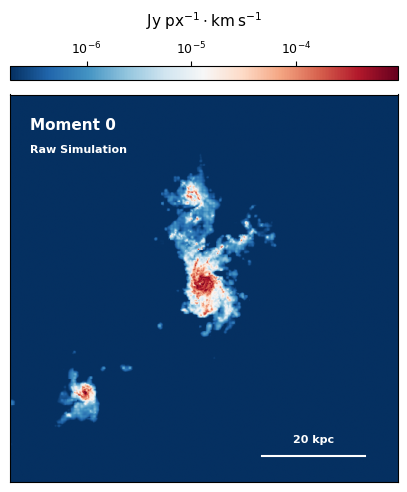

In [26]:

pix_spatial_scale = file_tot['pix_size_x'][()] * 3.2407792896664e-22

kpc = 20

cdelt = velocity_km_per_s[1]-velocity_km_per_s[0]

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get image shape and extent in kpc
ny, nx = spectral_cube_jy_px.shape[1], spectral_cube_jy_px.shape[2]
x_max = nx# * pix_spatial_scale
y_max = ny# * pix_spatial_scale
extent = [0, x_max, 0, y_max]  # (xmin, xmax, ymin, ymax)

# Define tick locations (in kpc)
num_ticks = 5
tick_locs = np.linspace(0, x_max, num_ticks)
tick_labels = [f"{tick:.1f}" for tick in tick_locs]



from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create axes and divider
fig, ax = plt.subplots(figsize=(5, 5.5))
divider = make_axes_locatable(ax)

# Main image
im = ax.imshow(
    np.rot90(np.rot90((spectral_cube_jy_px).sum(axis=0)*cdelt)),
    norm=mpl.colors.SymLogNorm(
        vmin=cdelt*10 ** (-5.2) / (1 + z) ** 3,
        vmax=cdelt*10 ** (-1.5) / (1 + z) ** 3,
        linthresh=1e-16 / (1 + z) ** 3
    ),
    cmap='RdBu_r'
)

# Top colorbar axis
cax = divider.append_axes("top", size="3.5%", pad=0.15)
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')

# Customize colorbar
cbar.set_label(r'$\rm Jy \; px^{-1} \cdot km \: s^{-1}$', rotation=0, labelpad=10, fontsize=11)
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.tick_params(axis='x', labelsize=9)


ax.text(x_max * 0.05, y_max * 0.91, 'Moment 0', color='white', fontsize=11, weight='bold')
ax.text(x_max * 0.05, y_max * 0.85, 'Raw Simulation', color='white', fontsize=8, weight='bold')
#add_beam(ax, 5*(500/96), 5*(500/96), 0, xy_offset=(30, 30), color='white')

# Add scalebars
scalebar_length = kpc/pix_spatial_scale  # in kpc
x0 = x_max * 0.65
y0 = y_max * 0.067

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')


# Scalebar for Moment 0
ax.plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=1.5)
ax.text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
           color='white', ha='center', va='bottom', fontsize=8, weight='bold')


plt.savefig('figures/moment0_raw_sim.pdf', bbox_inches='tight')
plt.show()


146.2837033278956


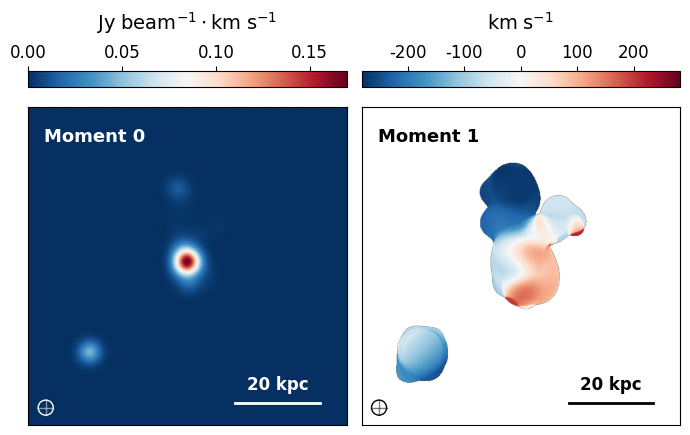

In [29]:
from astrodendro import Dendrogram


clean_cube_beam = convolve_beam(spectral_cube_jy_px, 5*(550/96))

pix_spatial_scale = file_tot['pix_size_x'][()] * 3.2407792896664e-22

kpc = 20

mask = np.zeros(clean_cube_beam.shape, dtype=bool)
d1 = Dendrogram.compute(clean_cube_beam, min_value=0.15 * clean_cube_beam.std(), min_delta=0.15*clean_cube_beam.std(), verbose=False)
for trunk in d1.trunk:
    mask |= trunk.get_mask()


import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get image shape and extent in kpc
ny, nx = clean_cube_beam.shape[1], clean_cube_beam.shape[2]
x_max = nx# * pix_spatial_scale
y_max = ny# * pix_spatial_scale
extent = [0, x_max, 0, y_max]  # (xmin, xmax, ymin, ymax)

# Define tick locations (in kpc)
num_ticks = 5
tick_locs = np.linspace(0, x_max, num_ticks)
tick_labels = [f"{tick:.1f}" for tick in tick_locs]




fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharex=True, sharey=True)

# Plot 1: moment 0 map
im0 = ax[0].imshow(np.rot90(np.rot90(clean_cube_beam.sum(axis=0)*cdelt)), cmap='RdBu_r', origin='lower', extent=extent)
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("top", size="5%", pad=0.2)
cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal', format='%.2f')
cb0.set_label(r'$\rm Jy \; beam^{-1} \cdot km \; s^{-1}$', rotation=0, labelpad=10, fontsize=15)
cb0.ax.xaxis.set_label_position('top')
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.label.set_size(14)
cb0.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb0.ax.xaxis.labelpad = 10
ax[0].text(x_max * 0.05, y_max * 0.89, 'Moment 0', color='white', fontsize=13, weight='bold')
add_beam(ax[0], 5*(500/96), 5*(500/96), 0, xy_offset=(30, 30), color='white')



moment_cube = clean_cube_beam * velocity_km_per_s[:,np.newaxis, np.newaxis]  # Calculate the moment cube



# Plot 2: moment 1 map
numerator = (mask * moment_cube).sum(axis=0)
denominator = (mask * clean_cube_beam).sum(axis=0)
ratio = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)
max = np.max([np.abs(np.nanmin(ratio)), np.abs(np.nanmax(ratio))])
im1 = ax[1].imshow(np.rot90(np.rot90(ratio)), cmap='RdBu_r', origin='lower', extent=extent, vmin=-max, vmax=max)
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("top", size="5%", pad=0.2)
cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', format='%.0f')
cb1.set_label(r'$\rm km\;s^{-1}$', rotation=0, labelpad=10, fontsize=15)
cb1.ax.xaxis.set_label_position('top')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb1.ax.xaxis.label.set_size(14)
cb1.ax.xaxis.labelpad = 10
ax[1].text(x_max * 0.05, y_max * 0.89, 'Moment 1', color='black', fontsize=13, weight='bold')
add_beam(ax[1], 5*(500/96), 5*(500/96), 0, xy_offset=(30, 30), color='black')

# Remove ticks and labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel('')
    a.set_ylabel('')

# Add scalebars
scalebar_length = kpc/pix_spatial_scale  # in kpc
print(scalebar_length)
x0 = x_max * 0.65
y0 = y_max * 0.07

# Scalebar for Moment 0
ax[0].plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=2)
ax[0].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
           color='white', ha='center', va='bottom', fontsize=12, weight='bold')

# Scalebar for Moment 1
ax[1].plot([x0, x0 + scalebar_length], [y0, y0], color='black', lw=2)
ax[1].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
           color='black', ha='center', va='bottom', fontsize=12, weight='bold')


for a in ax:
    a.set_aspect('equal')  # or 'auto' if stretching is preferred


plt.tight_layout()
plt.savefig('figures/moment_maps_sim.pdf', bbox_inches='tight')
plt.show()




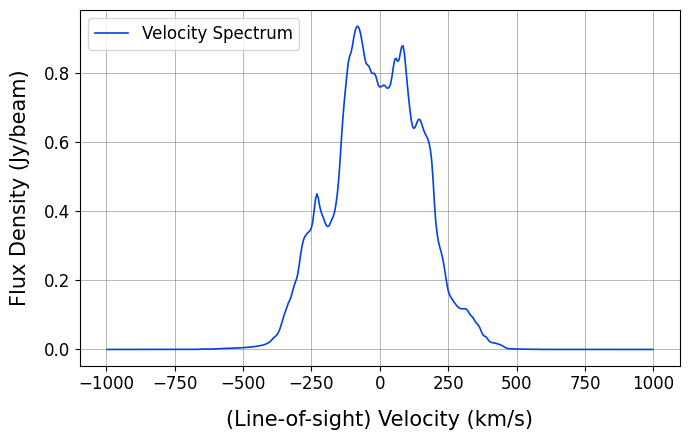

In [31]:
plt.figure(figsize = (7, 4.5))
#plt.plot(vels, np.sum(convolved_cube, axis=(1,2)), color='xkcd:blue', label='Velocity Spectrum', linewidth=0.8, alpha=0.3)
from scipy.ndimage import gaussian_filter1d
y_smooth = np.sum(clean_cube_beam, axis=(1,2))
plt.plot(velocity_km_per_s, y_smooth, color='xkcd:blue', label='Velocity Spectrum', linewidth=1.2)
plt.ylabel('Flux Density (Jy/beam)', fontsize=15, labelpad = 10)
plt.xlabel('(Line-of-sight) Velocity (km/s)', fontsize=15, labelpad = 12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend(fontsize = 12, loc='upper left')
plt.tight_layout()
plt.savefig('figures/init_velocity_spectrum_sim.pdf', bbox_inches='tight')
plt.show()